Version Date: April 28, 2021

# Objectives
- Gain proficiency in reading and modifying Python code in the Google Colab/Jupyter notebook environment
- Build machine learning binary classification models that predict the presence of a carbonyl group using IR spectroscopy data
- Learn about different machine learning classification models
- Learn how data preprocessing and analysis parameters affect the performance of machine learning models

# Getting started

- Begin by watching this [brief (3 minute) YouTube video introduction to Google Colab](https://www.youtube.com/watch?v=inN8seMm7UI) and/or [reading this short (1 page) introductory explanation](https://colab.research.google.com/notebooks/intro.ipynb)
- Colab notebooks consist of text cells (like this one) and program code cells, like the one shown below.  Code cells are executed by typing the Cmd+Enter keys (or Ctrl-Enter). You can also execute a code cell by mousing over the `[ ]` symbol in the upper left hand side of the code cell---when you hover over it it will turn into a "play" button, and clicking the play button will execute the code cell. You can find other options for executing groups of cells in the "Runtime" menu above.
- Start by executing the code cell below (the one that begins with the line `import pandas as pd`).  This loads ("imports") the required software modules that will be used in the assignment.




## Loading Python Libraries

In [1]:
%%capture
import pandas as pd     
import numpy as np

# for normalization  
from sklearn import preprocessing

# for visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# for data imbalance, SMOTE
from imblearn.over_sampling import SMOTE
from scipy import stats

# to calculate the performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

Take a moment to look at this code block:
- `import` loads a module 
- `import ... as` allows you to assign a short alias to the module
- `from ... import` loads a small portion of a module
- observe that the `import`, `as` and `from` keywords are color coded purple.  
- `#` indicates a comment (observe that all of the text following the `#` is color coded green).  This text is not interpreted by the computer, and its goal is to provide the human with some information about what is happening.  

What do each of these program modules do?  You can think of them as being like a library of books that accomplish program tasks.  In general, they can be quite complicated.  In most cases, you will never learn all of the functionality of a module, and will have to use the documentation to help you determine the relevant parts for solving your problem.  It is useful to have a general sense of the types of tasks that each of modules do, so that you can find the appropriate functionality.

- [pandas](http://pandas.pydata.org) is a library for handling datasets
- [numpy](https://numpy.org/) and [scipy](https://www.scipy.org/) are libraries for mathematical and scientific computing
- [matplotlib](https://matplotlib.org/) and [plotly](https://plotly.com/python/) are libraries for data visualization
- [sklearn](https://scikit-learn.org/stable/) and [imblearn](https://pypi.org/project/imblearn/) are libraries for machine learning

## Installing RDKit Module
- To look at the molecule structure, we will use the `RDKit` [module](https://www.rdkit.org/)
- The three code blocks below will install RDKit in Google Colab
- The installation process requires a kernel restart, so you will see a Google Colab error message saying that your session crashed after you run the first code block. Don't panic! Just rerun the notebook from the start to finish the installation.


In [2]:
%%capture
!pip install condacolab
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import condacolab
condacolab.install()

In [3]:
%%capture
import condacolab
condacolab.check()
!mamba install -c conda-forge rdkit

In [4]:
try:
  from rdkit import Chem
  from rdkit.Chem import Draw
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

## Basics of Python
Like other programming languages, Python includes variables and functions.

- **Variable** : a reserved memory location to store values.
Simply, it's like a container that holds data that can be changed later in the program. For example to create a variable named `number` and assign its value as `100`:

```
    number = 100
```

This variable can be modified at any time.
```
    number = 100
    number = 1 
```

The value of `number` has changed to 1.

- **Function** : a block of code which only runs when it is called. Functions are defined using the `def` keyword. Functions can take user-provided input values, called **arguments**.

For example, let's define an `absolute_value` function as below, which takes one argument, the number for which the absolute value should be calculated.
```
def absolute_value(num):
    if num >= 0:
        return num
    else:
        return -num
```
The output of `absolute_value(2)` is 2, and `absolute_value(-4)` is 4.

# Get Data
Now let's load in the training and test data sets, which are stored on GitHub. To do this, we will need to use a **module**.
Using a built-in method of a module is carried out by writing: `[module_name].[method]`

For example, to use the `read_csv` method of the `pandas` module: `pd.read_csv()`.  With this method, CSV files are read as a **DataFrame** structure, which is similar to a table. For more on DataFrames:
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) documentation



In [5]:
# load the training data and save it in the variable "train"
train=pd.read_csv('https://raw.githubusercontent.com/elizabeththrall/MLforPChem/main/MLforvibspectroscopy/Data/binary_train.csv',index_col=0)
# load the test data and save it in the variable "test"
test=pd.read_csv('https://raw.githubusercontent.com/elizabeththrall/MLforPChem/main/MLforvibspectroscopy/Data/binary_test.csv',index_col=0)

Let's see what these data look like. You can display the current contents of a variable by entering its name and executing the cell:


In [6]:
# display the contents of the variable "train"
train

,SMILES,name,label,500,502,504,506,508,510,512,514,516,518,520,522,524,526,528,530,532,534,536,538,540,542,544,546,548,550,552,554,556,558,560,562,564,566,568,570,572,...,3922,3924,3926,3928,3930,3932,3934,3936,3938,3940,3942,3944,3946,3948,3950,3952,3954,3956,3958,3960,3962,3964,3966,3968,3970,3972,3974,3976,3978,3980,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,COC1OCCO1,2-methoxy-13-dioxolane,0,0.000051,0.000051,0.000052,0.000052,0.000053,0.000053,0.000054,0.000054,0.000055,0.000056,0.000057,0.000057,0.000058,0.000059,0.000060,0.000062,0.000063,0.000064,0.000065,0.000066,0.000068,0.000069,0.000070,0.000071,0.000072,0.000073,0.000074,0.000075,0.000076,0.000077,0.000077,0.000077,0.000078,0.000078,0.000077,0.000077,0.000077,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
1,CCCCCC=O,hexanal,1,0.000121,0.000126,0.000131,0.000136,0.000141,0.000146,0.000151,0.000155,0.000159,0.000163,0.000166,0.000169,0.000171,0.000172,0.000172,0.000172,0.000171,0.000169,0.000166,0.000163,0.000159,0.000155,0.000150,0.000146,0.000141,0.000135,0.000130,0.000125,0.000120,0.000115,0.000111,0.000106,0.000102,0.000097,0.000093,0.000090,0.000086,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
2,CC1CCC(C)C1C,1R2R3S-123-trimethylcyclopentane,0,0.000013,0.000013,0.000013,0.000013,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000013,0.000013,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000014,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013
3,c1cn[se]c1,12-selenazole,0,0.000243,0.000244,0.000245,0.000246,0.000248,0.000249,0.000251,0.000254,0.000256,0.000259,0.000262,0.000266,0.000270,0.000274,0.000278,0.000283,0.000288,0.000294,0.000300,0.000306,0.000313,0.000320,0.000328,0.000336,0.000344,0.000353,0.000363,0.000372,0.000383,0.000394,0.000405,0.000416,0.000429,0.000441,0.000454,0.000467,0.000480,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003
4,CCC(C)=CC(C)C,3E-24-dimethylhex-3-ene,0,0.000053,0.000053,0.000054,0.000054,0.000054,0.000054,0.000054,0.000055,0.000055,0.000056,0.000056,0.000057,0.000058,0.000058,0.000059,0.000060,0.000062,0.000063,0.000064,0.000065,0.000067,0.000068,0.000069,0.000070,0.000072,0.000073,0.000074,0.000075,0.000075,0.000076,0.000076,0.000076,0.000075,0.000075,0.000074,0.000073,0.000071,...,0.000014,0.000014,0.000014,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0.000012,0

* The numbers to the left the first column (**0, 1, ...**) represent the index of each row
* Each row contains data for a different molecule
* The first column ("SMILES") contains the molecule SMILES string (more on that later)
* The second column ("name") contains the molecule name
* The third column ("label") contains a number indicating whether the molecule does (**1**) or does not (**0**) contain a carbonyl group
* The numbers at the top of the remaining columns (**500, 502, ..., 3998, 4000**) represent the vibrational frequency in wavenumbers, and the numbers below each frequency represent the vibrational intensity of each molecule at that frequency

We say that each frequency is a **feature**. A feature is an individual measurable property or characteristic of a phenomenon being observed.

## Data Selection with Pandas
We will often need to access the values stored in particular positions in a variable. We can do this using the indices corresponding to that position:
- `iloc[row index, column index] `is used for position based data selection
- `:` is used for selecting a range of index values
- Note that in Python, index values start from `0` instead of `1`

For example:
- `iloc[1:3,0]` : select row indices 1 to 2 (i.e., second and third rows) and the first column
- `iloc[:,0]` : select all rows and the first column
- `iloc[:,2:5]`: select all rows and column indices 2 to 4 (i.e., third through fifth columns)

In [7]:
# this line of code returns the first row and first column of the training data
train.iloc[0,0]

'COC1OCCO1'

In [8]:
# this line of code returns the first three rows and first 10 columns of the training data
train.iloc[0:3,0:10]

,SMILES,name,label,500,502,504,506,508,510,512
0,COC1OCCO1,2-methoxy-13-dioxolane,0,0.000051,0.000051,0.000052,0.000052,0.000053,0.000053,0.000054
1,CCCCCC=O,hexanal,1,0.000121,0.000126,0.000131,0.000136,0.000141,0.000146,0.000151
2,CC1CCC(C)C1C,1R2R3S-123-trimethylcyclopentane,0,0.000013,0.000013,0.000013,0.000013,0.000012,0.000012,0.000012


In [9]:
# guess what the output of this line of code will be
train.iloc[0:3,0:3]

,SMILES,name,label
0,COC1OCCO1,2-methoxy-13-dioxolane,0
1,CCCCCC=O,hexanal,1
2,CC1CCC(C)C1C,1R2R3S-123-trimethylcyclopentane,0


# Plotting Spectra
Before continuing, let's look at the spectra of a few molecules to see what they look like.

- For visualization: [plotly- line chart](https://plotly.com/python/line-charts/)
- You can add a trace by using 
`fig.add_trace(go.Scatter(x= [Independent Variable], y=[dependent Variable] )`
- You can choose which spectra to plot by changing the index values below

Note that the index values below refer to the row numbers in the training data DataFrame. For example, `idx_notCarbonyl=1` selects the molecule in row 0 of the training data, which is hexanal. If you want to select 12-selenazole in row 3 instead, change the line of code to read `idx_notCarbonyl=3`.

In [52]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:]
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

Notice that the spectra span the same frequency range, but the maximum intensity value is different for each molecule.

# Data Preprocessing
Before carrying out the machine learning analysis, we will need to preprocess the data to put it in a standard form. There are several steps involved: normalization, thresholding, splitting attribute and label, and data balancing.

## Normalization
In practice, different IR spectra may be recorded at different molecular concentrations, so the absolute intensities may not be directly comparable. Therefore we will **normalize** the data before carrying out the analysis.

We will apply a type of normalization called **min-max normalization** to each "instance" (i.e., molecule) and update the data.
- For each molecule, the spectral intensities will be scalled to **range from 0 to 1**
- We will use the [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) method

We will define a function called `df_normalize` to carry out this normalization:
- The first argument in the parentheses following the function name represents the data to be normalized
- The second argument represents the column index where the frequency data starts. If you don't provide this argument, the function uses a default value of `3`.
- As an example, if the frequency data in the variable `ex_data` starts in column `4`, you would write: `df_normalize(ex_data,4)`

In [11]:
# define a function to perform min-max normalization
def df_normalize(df,i=3):
  """
  apply min-max_scaler to each rows
  since min-max scaler originally applies to columns, 
  we will use transposed data and then update the data with transposed result
  """
  min_max_scaler = preprocessing.MinMaxScaler()
  df.iloc[:,i:] = min_max_scaler.fit_transform(df.iloc[:,i:].T).T

In [12]:
# use the functional to normalize the training and test data
df_normalize(train)
df_normalize(test)

## Apply Threshold
We expect that intensities near 0 won't provide much useful information for the classification. Therefore we will choose a threshold intensity and set all intensity values below the threshold equal to 0.

Let's look at the spectra of a few molecules and then choose the threshold. (Again you can choose which spectra to plot by changing the index values.)

In [13]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:]
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

We will use a default value of `threshold=0.2` to start, but you can change this value later to see how it affects model performance:

In [14]:
# set threshold value
threshold=0.2

We will define a function called `applyThreshold` to apply the threshold chosen above to the training and test data:
- This function uses the **numpy "where"** method to replace intensity values below the threshold with the value 0
- The first argument in the parentheses following the function name represents the data to be thresholded
- The second argument `i` represents the column index where the frequency data starts. If you don't provide this argument, the function uses a default value of `3`.
- As an example, if the frequency data in the variable `ex_data` starts in column `4`, you would write: `applyThreshold(ex_data,4)`

In [15]:
# define a function to apply the threshold chosen above
def applyThreshold (dataframe,i=3):
  """
  i is the position of the start of the attributes
  """
  dataframe.iloc[:,i:]=np.where((dataframe.iloc[:,i:]< threshold),0,dataframe.iloc[:,i:])

In [16]:
# use the function to apply the threshold to the training and test data
applyThreshold(train)
applyThreshold(test)

Let's see how the intensities changed after applying the threshold:

In [17]:
# change the index values below to pick molecules with and without a carbonyl
idx_hasCarbonyl=1
idx_notCarbonyl=0
# get the data for the two molecules
hasCarbonyl=train.set_index('name').iloc[idx_hasCarbonyl,3:] # picked
notCarbonyl=train.set_index('name').iloc[idx_notCarbonyl,3:] # picked 
# plot the spectra
fig = go.Figure()
fig.add_trace(go.Scatter(x=hasCarbonyl.index, y=hasCarbonyl, name=hasCarbonyl.name,mode='markers'))
fig.add_trace(go.Scatter(x=notCarbonyl.index, y=notCarbonyl,name=notCarbonyl.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)

## Split Attribute and Label
Notice that the training and test DataFrames contain the molecule name and label in addition to the spectral data. Now we need to separate the information about whether or not the molecule contains a carbonyl from the spectral intensities. We will do this by creating two new variables, X and Y:

X is an **attribute**, all the **normalized intensities**

Y is a **label** which is the **presence of a carbonyl group**. **If the molecule has a carbonyl then Y = 1; if it doesn't, then Y = 0**.

Define a function to split the labels and attributes:
- The first argument in the parentheses following the function name represents the data to be split
- The second argument `start_X` represents the column index where the frequency data starts. If you don't provide this argument, the function uses a default value of `3`.
- The third argument `end_X` represents the column index where the frequency data end. If you don't provide this argument, the function uses a default value of `None`.
- The fourth argument `start_Y` represents the column index where the label data start. If you don't provide this argument, the function uses a default value of `2`.
- The fifth argument `end_Y` represents the column index where the frequency data end. If you don't provide this argument, the function uses a default value of `3`.
- As an example, if the frequency data in the variable `ex_data` start in column `5` and the label data are in columns `3` and `4`, you would write: `splitXY(ex_data,5,None,3,5)`

In [18]:
# define a function to split the column containing the label from the columns containing the attributes
def splitXY(dataframe,start_X=3,end_X=None,start_Y=2,end_Y=3):
  X=dataframe.iloc[:,start_X:end_X]
  # since current X is a dataframe structure, we use ".value" to only get values
  X=X.values
  Y=dataframe.iloc[:,start_Y:end_Y]
  # since current Y is a dataframe structure, we use ".value" to only get values
  Y=Y.values.ravel()
  # this makes sure all the labels are integers
  Y=Y.astype(float).astype(int)
  return X,Y

In [19]:
# now apply the function to the normalized and thresholded train and test data
X,Y=splitXY(train)
X_test,Y_test=splitXY(test)

## Data Balancing

Let's visualize the data distribution with a pie chart to see if data are imbalanced. Here, imbalanced means that there are unequal numbers of molecules in the two classes (with and without a carbonyl).:

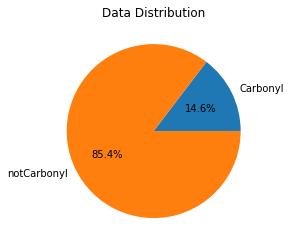

In [20]:
# get the total number of molecules in the training data
total=len(Y)
# determine how many contain a carbonyl
label1=Y.sum()
# find the number without a carbonyl by subtraction
label0=total-label1
# plot the data
data=[label1,label0]
my_labels = 'Carbonyl','notCarbonyl'
plt.pie(data,labels=my_labels,autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

Molecules without a carbonyl dominate the training set, so the classes are imbalanced.

### SMOTE (Synthetic minority oversampling technique)

Imbalanced training data can sometimes lead to poor classification performance because the model might simply learn to ignore the less common ("minority") class. To address this possibility, we will use a technique called [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) which generates new instances of the minority class by interpolating between the existing instances. (Note that if the two classes are sufficiently distinct, as is the case here, a data balancing step may not be required -- but we'll do it anyway.)

In [21]:
%%capture
# define SMOTE method
sm = SMOTE(ratio='minority')
# apply SMOTE to the training data
X, Y= sm.fit_sample(X,Y)

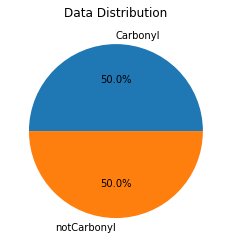

In [22]:
# again determine the number of molecules with and without carbonyl groups and visualize
total=len(Y)
label1=Y.sum()
label0=total-label1
data=[label1,label0]
my_labels = 'Carbonyl','notCarbonyl'
plt.pie(data,labels=my_labels,autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

Now the training data are balanced between the two classes. We can plot one of the new synthetic carbonyl-containing spectra for comparison to a real carbonyl-containing spectrum. (The synthetic spectrum will vary each time you run SMOTE.)

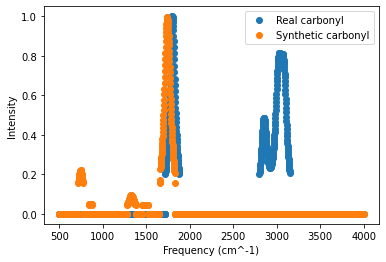

In [53]:
# index values of a real and synthetic carbonyl (you can change these values to see other spectra)
idx_realCarbonyl=1 # this selects the molecule in row 1 of the training data (hexanal)
idx_synCarbonyl=len(train) # this selects the first synthetic carbonyl spectrum
# get the data for the two molecules
spectrum_realCarbonyl=X[idx_realCarbonyl,:]
spectrum_synCarbonyl=X[idx_synCarbonyl,:]
# get the frequencies for plotting
frequencies=range(500,4002,2)
# generate the plot
plt.plot(frequencies,spectrum_realCarbonyl,"o",label="Real carbonyl") 
plt.plot(frequencies,spectrum_synCarbonyl,"o",label="Synthetic carbonyl")
plt.legend(loc="upper right")
plt.xlabel("Frequency (cm^-1)")
plt.ylabel("Intensity")
plt.show()

# Building Machine Learning Models

## Introduction to Machine Learning Models

Now that the data preprocessing is done, we're finally ready to build our machine learning models! Initially we will use two different classifier models implemented in the `scikit-learn` library:
- Decision Tree
- Random Forest

A few other useful classifiers contained in `scikit-learn`, which you can test later, are:
- kNN (k-Nearest Neighbors)
- Naive Bayes

These models all have a set of default parameters, but you can adjust the parameters by providing additional arguments for the functions. Information is provided in the `scikit-learn` information link. Here we will use the default parameters for the Decision Tree and Random Forest algorithm.

Below are descriptions of these four models.

**Decision Tree**

Decision Tree a tree-like model of decisions. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed.
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) documentation 


**Random Forest**

Random Forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes.
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Random_forest)
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation

**k-Nearest Neighbors**

k-NN is a model that classifies data points based on the points that are most similar to it. A case is classified by a majority vote of its neighbors, with the case being assigned to the class most common amongst its k nearest neighbors measured by a distance function.

- [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) documentation

**Naive Bayes**

Naive Bayes is an algorithm based on Bayes’ theorem.  The term “Naive” refers to the assumption that input features independent. Although this assumption is often violated, the model can still perform well.
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) documentation

## Training a Decision Tree Model
Let's start by training a Decision Tree model. Use the normalized and thresholded training data to fit the model.

In [24]:
# use the Decision Tree algorithm with the default parameters
dt_clf=DecisionTreeClassifier()
# fit the model using the training data set
dt_clf.fit(X,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Training a Random Forest Model
Now let's do the same thing but for a Random Forest model.

In [25]:
# use the Random Forest algorithm with the default parameters
rf_clf=RandomForestClassifier()
# fit the model using the training data set
rf_clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Testing Machine Learning Models
Now that we have trained our machine learning models, we can use them on test data. There are a few steps in this process:
1. Label Prediction: 

We will use the fitted machine learning models to predict the labels (with or without carbonyl) for the test data set. We will store the predictions made by the fitted models in the `Y_pred` list.

2. Model Evaluation:

It's important to see how well the models performed. There are [a few ways](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) to assess the accuracy of a machine learning model:
- Accuracy : the proportion of the total number of predictions that were correct
- Sensitivity or Recall : the proportion of actual positive cases (here, molecules with a carbonyl) which are correctly identified
- Specificity : the proportion of actual negative cases (here, molecules without a carbonyl) which are correctly identified

3. False Negative and False Positive Group

Finally, we can analyze the error cases, where the model's prediction was wrong. A false positive (FP) is an outcome where the model incorrectly predicts the positive class. A false negative (FN) is an outcome where the model incorrectly predicts the negative class. Sometimes we might be able to understand why the prediction was incorrect for a particular molecule by:

- Looking at the molecular structure. (We will use the `RDkit` module for this task.)
-Looking at the molecular spectrum.

## Test the Decision Tree Model
Now let's use the fitted Decision Tree model for label prediction. Then we'll analyze the performance by displaying the accuracy, sensitivity, and specificity.

In [26]:
# use the fitted Decision Tree model to predict the labels (with or without carbonyl) for the test data set
Y_pred=dt_clf.predict(X_test)

In [27]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
dt_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
dt_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
dt_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(dt_accuracy)+" Sensitivity: "+str(dt_sensitivity)+" Specificity: "+str(dt_specificity))

Accuracy: 0.97 Sensitivity: 0.93 Specificity: 0.98


## Test the Random Forest Model
Now let's use the fitted Random Forest model for label prediction. Then we'll analyze the performance by displaying the accuracy, sensitivity, and specificity.

In [28]:
# use the fitted Random Forest model to predict the labels (with or without carbonyl) for the test data set
Y_pred=rf_clf.predict(X_test)

In [29]:
# determine the accuracy, sensitivity, and specificity by comparing the predicted labels to the actual labels
rf_accuracy=np.round(accuracy_score(Y_test,Y_pred),2)
rf_sensitivity=np.round(recall_score(Y_test,Y_pred),2)
rf_specificity=np.round(recall_score(Y_test,Y_pred,pos_label=0),2)

# display the accuracy, sensitivity, and specificity
print("Accuracy: "+str(rf_accuracy)+" Specificity: "+str(rf_sensitivity)+" Specificity: "+str(rf_specificity))

Accuracy: 0.98 Specificity: 1.0 Specificity: 0.98


# FP / FN Group Analysis
Now let's look more carefully at the FPs and FNs. First we need to determine which predictions were incorrect and separate them into the two types of errors.

Note that for both the Decision Tree and the Random Forest, we saved the predictions in the same variable: `Y_pred`. Thus `Y_pred` currently contains the predictions of whichever analysis you ran most recently. If you went straight through the file, that would be the Random Forest model.

Thus to see the FPs and FNs for the Decision Tree model, we will first rerun the prediction using the Decision Tree model. If you would like to use the code below to see the FPs and FNs for a different model, change the first line below to store the predictions of a different model in Y_pred.

In [30]:
# rerun the label prediction (change the line below to specify which model to use)
Y_pred=dt_clf.predict(X_test)

# create new variables to hold the indices (i.e., row number) of all FPs and FNs
fp=[]
fn=[]

# go through all predictions to identify the errors and then determine whether each one is an FP or FN
for i in range (len(Y_test)):
  # identify FPs and store their indices
  if Y_pred[i] != Y_test[i] and Y_test[i] ==0:
       fp.append(i)
  # identify FNs and store their indices
  elif Y_pred[i] != Y_test[i] and Y_test[i]==1:
       fn.append(i)

## Utilizing `RDkit` to get the molecule structure

We can use the `RDkit` library to display the structure of a molecule. To identify the molecule, we use the Simplified Molecular Input Line Entry System, or [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). SMILES is an unique chemical identifier in the form of an ASCII string. First we will go through the lists of FPs and FNs to get the SMILES strings and molecule names.


In [31]:
# get the SMILES strings
fpmols=test.iloc[fp,0].values 
# get the molecule name
fpmols_name=test.iloc[fp,1].values 

# get the SMILES strings 
fnmols=test.iloc[fn,0].values 
# get the molecule names
fnmols_name=test.iloc[fn,1].values

# get lists of the FP and FN SMILES strings
fp_list = [Chem.MolFromSmiles(smiles) for smiles in fpmols]
fn_list = [Chem.MolFromSmiles(smiles) for smiles in fnmols]

In [32]:
# set molecule names for the FP plot displayed below
for i in range(len(fp_list)):
  mol=fp_list[i]
  mol.SetProp("_Name",fpmols_name[i])

# set molecule names for the FN plot displayed below
for i in range(len(fn_list)):
  mol=fn_list[i]
  mol.SetProp("_Name",fnmols_name[i])

Now let's display tables showing the index, name, and SMILES string of any FPs and FNs. Note that if the model performance was very good, there might not be any FPs and/or FNs, so the table(s) will be empty in that case.

In [33]:
# display a table showing the index, SMILES string, and name of all FPs
print('\033[1m' + 'FP List' + '\033[0m')
test.iloc[fp, 0:2]

FP List


,SMILES,name
78,[O][N]O,nitrous-acid-trans
105,F[CrH],chromium-fluoride-hydride
182,[CrH2],chromium-dihydride


In [34]:
# display a table showing the index, SMILES string, and name of all FNs
print('\033[1m' + 'FN List' + '\033[0m')
test.iloc[fn, 0:2]

FN List


,SMILES,name
60,O=C(Cl)c1ccc(C(=O)Cl)cc1,terephthaloyl-chloride
137,CC(=O)CC(C)(C)O,diacetone-alcohol
183,Cc1ccccc1C=O,o-tolualdehyde


**FP Group**

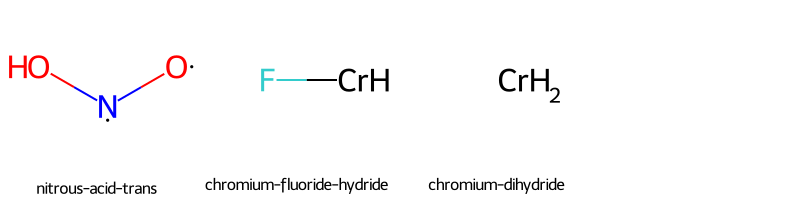

In [35]:
# display the molecular structures of all FPs
img1=Chem.Draw.MolsToGridImage(fp_list,molsPerRow=4,subImgSize=(200,200),legends=[mol.GetProp('_Name') for mol in fp_list])
img1

**FN Group**

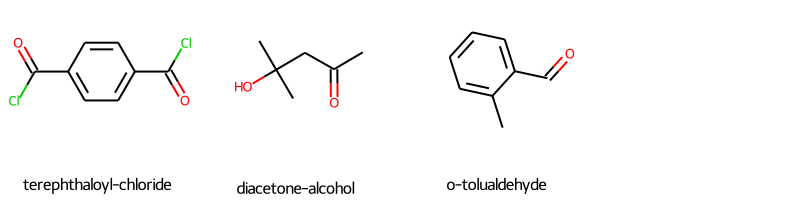

In [36]:
# display the molecular structures of all FNs
img2=Chem.Draw.MolsToGridImage(fn_list,molsPerRow=4,subImgSize=(200,200),legends=[mol.GetProp('_Name') for mol in fn_list])
img2

## Displaying FP or FN Spectrum

Edit the molecule index below to display the spectrum of a particular FP or FN for inspection. Do you see any spectral features that might explain the error?

In [37]:
# to display the spectrum of a FP
# in the line below, insert the index value of the molecule you want to see from the table above
fp_idx=78
# then display the figure
fp_mol=test.set_index('name').iloc[fp_idx,3:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=fp_mol.index, y=fp_mol, name=fp_mol.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)
fig.update_layout(showlegend=True)

In [42]:
# to display the spectrum of a FN
# in the line below, insert the index value of the molecule you want to see from the table above
fn_idx=137
# then display the figure
fn_mol=test.set_index('name').iloc[fn_idx,3:]
fig = go.Figure()
fig.add_trace(go.Scatter(x=fn_mol.index, y=fn_mol, name=fn_mol.name,mode='markers'))
fig.update_layout(title='Intensities over frequency',title_x=0.5)
fig.update_layout(showlegend=True)

# Assessing Overall Model Performance

As you use other machine learning models to perform this classification task, you can create a table to display the performance metrics (accuracy, sensitivity, and specificity) for each model. To each of the variables below, add the new variables that you create for the other models, separated by commas.


In [39]:
# create variables containing the performance metrics for each of the models
acs=[dt_accuracy,rf_accuracy]
sens=[dt_sensitivity,rf_sensitivity]
specs=[dt_specificity,rf_specificity]

To make a table, set the column names and values using a Dictionary data structure and then make it a DataFrame. Add the other model names in the list below (in single quotes and separated by commas) to add them to the table.


In [40]:
# make and display a DataFrame
d = {'Model':['Decision Tree','Random Forest'],'Accuracy':acs, 'Sensitivity':sens,' Specificity':specs}
result = pd.DataFrame(data=d)

In [41]:
result

,Model,Accuracy,Sensitivity,Specificity
0,Decision Tree,0.97,0.93,0.98
1,Random Forest,0.98,1.00,0.98
